In [1]:
# Cell 1 Imports and Setup
import os, sys
sys.path.append(os.path.abspath("..")) # allow importing scripts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import scripts.text_processing # Import the script as a module

# Force the script to reload after modifications
importlib.reload(scripts.text_processing) 

# Import the functions from the reloaded module
from scripts.text_processing import clean_text, headline_length, publisher_domain, prepare_corpus, lda_topics

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

In [2]:
# Cell 2 - load raw news csv 
RAW_PATH = "../data/raw_analyst_ratings.csv" 
df = pd.read_csv(RAW_PATH, parse_dates=['date'], dayfirst=False)
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:
# Cell 3 - headline length stats
hl = headline_length(df, col='headline') # returns DataFrame with chars,tokens
df = pd.concat([df, hl], axis=1)

print("Headline length (chars) — describe:")
display(df['chars'].describe().round(1))
print("\nHeadline length (tokens) — describe:")
display(df['tokens'].describe().round(1))

# top long headlines
display(df[['headline','chars','tokens']].sort_values('chars', ascending=False).head(10))

Headline length (chars) — describe:


count    1407328.0
mean          73.1
std           40.7
min            3.0
25%           47.0
50%           64.0
75%           87.0
max          512.0
Name: chars, dtype: float64


Headline length (tokens) — describe:


count    1407328.0
mean          11.4
std            6.4
min            1.0
25%            7.0
50%           10.0
75%           13.0
max           77.0
Name: tokens, dtype: float64

,headline,chars,tokens
701748,JinkoSolar Tiger Pro Series Receives World's F...,512,77
238137,Check Point® Software Technologies Ltd. (NASDA...,509,68
172392,Shares of several financial services companies...,458,70
753834,Shares of several financial services companies...,458,70
140048,Shares of several financial services companies...,458,70
1148612,Shares of several financial services companies...,458,70
1038290,Shares of several financial services companies...,458,70
1030792,Shares of several financial services companies...,458,70
1279768,Shares of several financial services companies...,458,70
644814,Shares of several financial services companies...,458,70


Top 20 publishers by article count:


publisher_name
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


Top 20 domains (if emails/domains used):


publisher_domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64

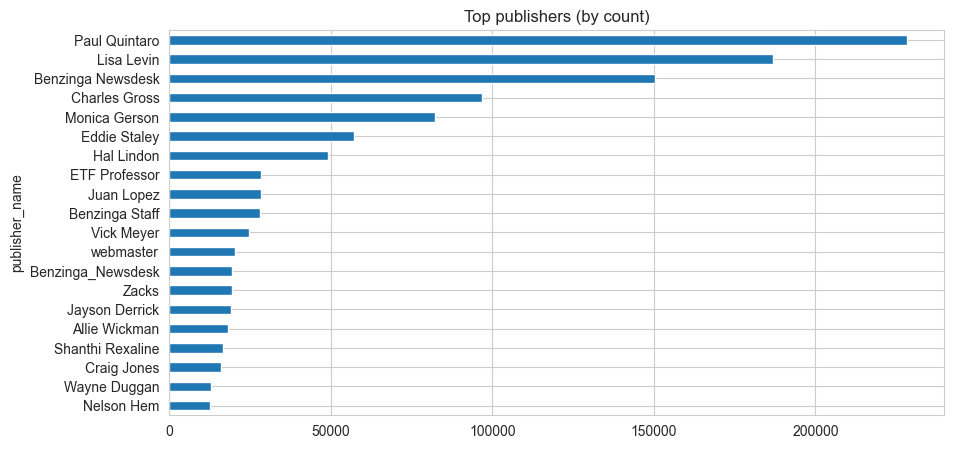

In [4]:
# Cell 4 - publishers and domain extraction
df['publisher_name'] = df['publisher'].fillna('').astype(str)
df['publisher_domain'] = df['publisher_name'].apply(publisher_domain)

# counts
pub_counts = df['publisher_name'].value_counts().head(20)
domain_counts = df['publisher_domain'].value_counts().head(20)

print("Top 20 publishers by article count:")
display(pub_counts)
print("\nTop 20 domains (if emails/domains used):")
display(domain_counts)

# plot top publishers
plt.figure(figsize=(10,5))
pub_counts.plot(kind='barh')
plt.title("Top publishers (by count)")
plt.gca().invert_yaxis()
plt.show()

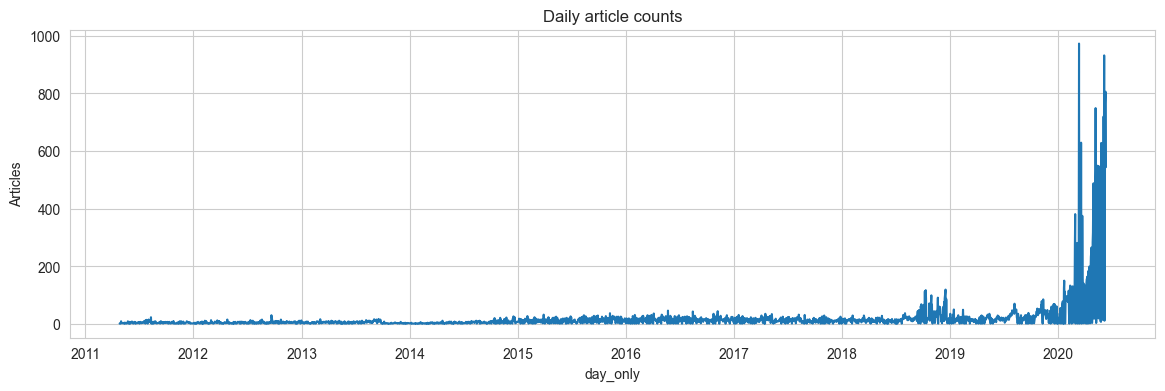

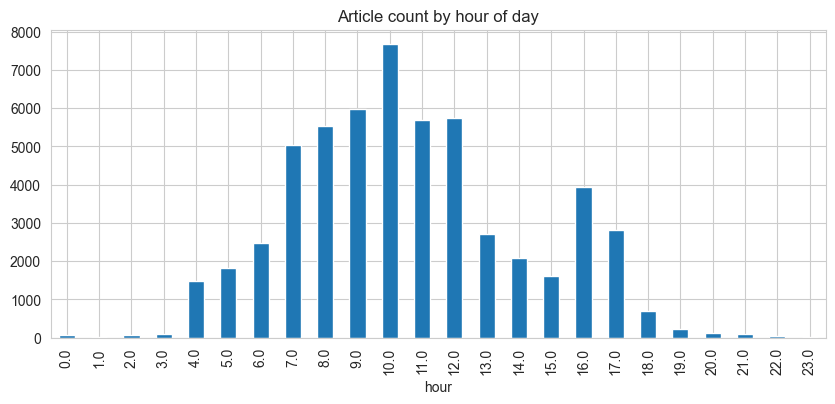

In [5]:
# Cell 5 - publications over time
import matplotlib.pyplot as plt
import pandas as pd

date_col_name = 'date'

# Explicity convert the column to datetime objects
df[date_col_name] = pd.to_datetime(df[date_col_name], errors='coerce')

# daily counts

df['day_only'] = df[date_col_name].dt.date
daily_counts = df.groupby('day_only').size()
plt.figure(figsize=(14,4))
daily_counts.plot()
plt.title("Daily article counts")
plt.ylabel("Articles")
plt.show()

# hourly distribution (time of day)
df['hour'] = df[date_col_name].dt.hour
hour_counts = df['hour'].value_counts().sort_index()
plt.figure(figsize=(10,4))
hour_counts.plot(kind='bar')
plt.title("Article count by hour of day")
plt.show()


In [12]:
# Cell 5.5 - Create Sampled DataFrame for faster LDA
# Set the sample size (e.g., 20,000 documents)
SAMPLE_SIZE = 20000 

if len(df) > SAMPLE_SIZE:
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).copy()
    print(f"Created sample of {len(df_sample)} documents for LDA.")
else:
    df_sample = df.copy()
    print("DataFrame size is small enough; using full dataset.")

Created sample of 20000 documents for LDA.


In [13]:
# Cell 6 - simple LDA on headlines or body
# Use the sampled DataFrame: df_sample
texts = df_sample['headline'].fillna('').astype(str).tolist() 

dictionary, corpus, texts_tok = prepare_corpus(texts, no_below=3, no_above=0.5, keep_n=2000) 
lda_model, topics = lda_topics(dictionary, corpus, texts_tok, num_topics=6, passes=3) 

print("LDA topics:")
for t in topics:
    print(t)

LDA topics:
(0, '0.043*"sales" + 0.036*"eps" + 0.032*"estimate" + 0.016*"america" + 0.014*"guidance" + 0.014*"price" + 0.013*"adj" + 0.012*"yoy"')
(1, '0.043*"shares" + 0.028*"update" + 0.025*"market" + 0.021*"share" + 0.014*"morgan" + 0.012*"mid" + 0.012*"company" + 0.011*"option"')
(2, '0.053*"earnings" + 0.032*"mid" + 0.027*"stocks" + 0.026*"market" + 0.025*"scheduled" + 0.025*"day" + 0.024*"biggest" + 0.021*"movers"')
(3, '0.086*"est" + 0.070*"stocks" + 0.055*"reports" + 0.055*"eps" + 0.046*"top" + 0.038*"week" + 0.027*"benzinga" + 0.019*"sales"')
(4, '0.028*"shares" + 0.023*"trading" + 0.022*"companies" + 0.016*"oil" + 0.016*"several" + 0.016*"lower" + 0.016*"says" + 0.016*"higher"')
(5, '0.034*"buy" + 0.031*"announces" + 0.023*"price" + 0.023*"maintains" + 0.021*"target" + 0.020*"raises" + 0.020*"downgrades" + 0.019*"upgrades"')


In [8]:
# Cell 7 - top keywords with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df['headline'].fillna('').astype(str).tolist()
tf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')
X = tf.fit_transform(corpus)
# compute top terms by average tfidf
import numpy as np
tfidf_means = np.asarray(X.mean(axis=0)).ravel()
terms = np.array(tf.get_feature_names_out())
top_idx = tfidf_means.argsort()[-30:][::-1]
print("Top TF-IDF keywords/phrases:")
for term, score in zip(terms[top_idx], tfidf_means[top_idx]):
    print(f"{term} : {score:.4f}")

Top TF-IDF keywords/phrases:
stocks : 0.0228
vs : 0.0180
market : 0.0176
est : 0.0164
earnings : 0.0159
benzinga : 0.0157
reports : 0.0149
eps : 0.0146
shares : 0.0145
update : 0.0140
downgrades : 0.0133
upgrades : 0.0130
announces : 0.0123
buy : 0.0119
week : 0.0118
pt : 0.0115
sales : 0.0106
raises : 0.0096
52 : 0.0096
price : 0.0095
mid : 0.0091
target : 0.0090
new : 0.0090
says : 0.0090
52 week : 0.0088
maintains : 0.0086
trading : 0.0086
scheduled : 0.0084
earnings scheduled : 0.0083
day : 0.0081


In [9]:
# Cell 8 - save summary CSVs for later
os.makedirs("../data/summary", exist_ok=True)
daily_counts.to_csv("../data/summary/daily_article_counts.csv")
pd.DataFrame(pub_counts).to_csv("../data/summary/top_publishers.csv")